## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
import gc
import re
import warnings

warnings.filterwarnings("ignore")

In [2]:
from string import punctuation

In [3]:
# vstack - adds rows, hstack - adds columns
# csr_matrix - used to handle sparse matrix
from scipy.sparse import vstack, hstack, csr_matrix

In [4]:
# CountVectorizer - Simply, counts word frequencies 
# TFIDF - More importance/weights on "rare" words. Less importance/weights on "frequent" words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# LabelBinarizer - Converts labels into numerical representation "G,B,R" -> [1,2,3]
from sklearn.preprocessing import LabelBinarizer

In [6]:
# Ridge - Reduces multicollinearity in regression. Applies L2 Regularization
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

%matplotlib inline

C:\Users\Shringa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
"""
#importing packages
from collections import Counter, defaultdict
import math
import json
import numpy as np
import os
import pandas as pd
import re
import pydotplus
from sklearn import tree, preprocessing
from sklearn_pandas import DataFrameMapper, cross_val_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import csr_matrix
from IPython.display import Image  

"""

'\n#importing packages\nfrom collections import Counter, defaultdict\nimport math\nimport json\nimport numpy as np\nimport os\nimport pandas as pd\nimport re\nimport pydotplus\nfrom sklearn import tree, preprocessing\nfrom sklearn_pandas import DataFrameMapper, cross_val_score\nfrom nltk.corpus import stopwords\nfrom nltk.stem.snowball import SnowballStemmer\nfrom scipy.sparse import csr_matrix\nfrom IPython.display import Image  \n\n'

## Reading the data

In [8]:
file = "Consumer_Complaints.csv"
cmplnts = pd.read_csv(file, na_values = "null")

In [9]:
# Determining the total size of the dataset
cmplnts.shape

(1124716, 18)

### Splitting data into train and test datasets

In [10]:
train,test = train_test_split(cmplnts, test_size=0.3)
print (train.shape, test.shape)

(787301, 18) (337415, 18)


In [11]:
# Create combined set. You would want to apply count vectorizer on combined set so you can get the list of all possible words.
combined = pd.concat([train,test])

# Create the submission set (Only contains the test ID)
test['test_id']= test.index
submission = test[['test_id']]

# Create size of train
train['train_id']= train.index
train_size = len(train)

In [12]:
combined.shape

(1124716, 18)

In [13]:
combined_ML = combined.sample(frac=0.1).reset_index(drop=True)

In [14]:
combined_ML.shape

(112472, 18)

## Training Set

Training set has 787301 observations with 11 features:



In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787301 entries, 830888 to 670492
Data columns (total 19 columns):
Date received                   787301 non-null object
Product                         787301 non-null object
Sub-product                     622932 non-null object
Issue                           787301 non-null object
Sub-issue                       430122 non-null object
Consumer complaint narrative    226385 non-null object
Company public response         258989 non-null object
Company                         787301 non-null object
State                           777131 non-null object
ZIP code                        727207 non-null object
Tags                            107881 non-null object
Consumer consent provided?      401686 non-null object
Submitted via                   787301 non-null object
Date sent to company            787301 non-null object
Company response to consumer    787296 non-null object
Timely response?                787301 non-null object
Cons

In [16]:
#Addign state codes DC (Washington D.C.), PR (Puerto Rico),{AE,AA,AP} (Armed Forces),VI (Virgin Islands),GU (Guam),FM(Federated States of Micronesia),
# AS (American Samoa),MP (Northern Mariana Islands),MH (Marshall Islands),PW (Palau)

states =['AA','AE','AK','AL','AP','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO',
         'MP','MH','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','PW','RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI',
         'WV','WY','UNITED STATES MINOR OUTLYING ISLANDS']

In [17]:
train.nunique()

Date received                     2486
Product                             18
Sub-product                         76
Issue                              166
Sub-issue                          218
Consumer complaint narrative    219626
Company public response             10
Company                           4637
State                               63
ZIP code                         23252
Tags                                 3
Consumer consent provided?           4
Submitted via                        6
Date sent to company              2429
Company response to consumer         8
Timely response?                     2
Consumer disputed?                   2
Complaint ID                    787301
train_id                        787301
dtype: int64

### Summary Statistics

1) There are 8 uniques categories of Company responses.  
2) Most of the complaints were for **Mortgage** and majorly the issue were in **Loan modification,collection and in foreclosure**.  
3) There are **6,800** complaints does not have any Consumer complaint narrative.  
4) Company which got most of the comlaints is **EQUIFAX, INC**.  
5) Most of the complaints were **closed by providing explanations** only.  

In [18]:
train.astype('object').describe().transpose()

,count,unique,top,freq
Date received,787301,2486,09/08/2017,2484
Product,787301,18,Mortgage,184810
Sub-product,622932,76,Credit reporting,104937
Issue,787301,166,"Loan modification,collection,foreclosure",78520
Sub-issue,430122,218,Account status,25893
Consumer complaint narrative,226385,219626,There are many mistakes appear in my report wi...,368
Company public response,258989,10,Company has responded to the consumer and the ...,170487
Company,787301,4637,"EQUIFAX, INC.",66208
State,777131,63,CA,109582
ZIP code,727207,23252,300XX,3867


In [19]:
train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,train_id
830888,11/13/2015,Credit card,NaN,Credit determination,NaN,NaN,Company chooses not to provide a public response,BARCLAYS BANK DELAWARE,TN,377XX,NaN,Consent not provided,Web,11/17/2015,Closed with non-monetary relief,Yes,No,1654084,830888
526856,02/11/2013,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,NJ,07111,NaN,NaN,Web,02/13/2013,Closed with explanation,Yes,No,314145,526856
591472,08/04/2015,Credit card,NaN,Other,NaN,NaN,Company chooses not to provide a public response,"CITIBANK, N.A.",AZ,85718,Older American,Consent not provided,Web,08/04/2015,Closed with monetary relief,Yes,No,1500828,591472
221150,03/22/2018,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,Company believes it acted appropriately as aut...,"Simon’s Agency, Inc",NJ,07740,NaN,NaN,Fax,03/30/2018,Closed with explanation,Yes,NaN,2851121,221150
744204,12/31/2017,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NaN,NaN,"BAYVIEW LOAN SERVICING, LLC",GA,30705,NaN,Other,Web,12/31/2017,Closed with explanation,Yes,NaN,2768499,744204


In [20]:

def _isdate(datestring):
    mat = re.match('(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})$', datestring)

    try:
        if mat:
            # xdate = datetime.datetime(*(map(int, mat.groups()[-1::-1])))
            return True
        else:
            return False
    except ValueError:
        print("err - isdate")




def _get_dtype(xstr):

    if re.match("^\d+?\.\d+?$", xstr):
        return "float"
    elif xstr.isdigit():
        return "int"
    elif _isdate(xstr):
        return "date"
    else:
        return "string"



def process_dtypes(data, tapply=False, thr=10):
        features = defaultdict(list)
        n = len(data)

        for col, val in data.iloc[3, :].iteritems():
            val = str(val).strip()
            val_type = _get_dtype(val)
            unq = data[col].nunique()

            if unq > n*.95:
                features["skip"].append(col)
                continue
            try:
                if(val_type == "int" or val_type == "float"):
                    if unq >= thr:
                        features["numfeatures"].append(col)
                        if tapply:
                            if val_type == "int" and data[col].dtype != 'int':
                                data[col] = data[col].astype(np.int64)
                            elif val_type == 'float' and data[col].dtype != 'float':
                                data[col] = data[col].astype(np.float64)
                    else:
                        features["catfeatures"].append(col)
                        if tapply:
                            print("feature ", col, " contains ", unq,
                                  " unique values, converted to categorical encoding")
                            data[col] = data[col].astype('category')
                elif val_type == "string":
                    if unq <= thr:
                        features["catfeatures"].append(col)
                        if tapply:
                            data[col] = data[col].astype('category')
                    else:
                        if tapply:
                            print("feature ", col, " contains ", unq,
                                  " unique values, converted to numeric encoding")
                            data[col] = data[col].astype('category')
                            data[col] = data[col].cat.codes
                            features["encode"].append(col)
                        else:
                            features["encode"].append(col)

                elif val_type == "date":
                    features["dtfeatures"].append(col)
                    if tapply:
                        data[col] = pd.to_datetime(data[col])

            except ValueError as verror:
                print(verror, "\n Data Contains N/A values in :", col)

       # self.features = features

        return features


In [21]:
#features = process_dtypes(train, tapply = True, thr=30)

In [22]:
train['Product'] = train['Product'].astype('category')
train['Sub-product'] = train['Sub-product'].astype('category')
train['Issue'] = train['Issue'].astype('category')
train['Sub-issue'] = train['Sub-issue'].astype('category')
train['Company public response'] = train['Company public response'].astype('category')
train['Consumer consent provided?'] = train['Consumer consent provided?'].astype('category')
train['Company response to consumer'] = train['Company response to consumer'].astype('category')

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787301 entries, 830888 to 670492
Data columns (total 19 columns):
Date received                   787301 non-null object
Product                         787301 non-null category
Sub-product                     622932 non-null category
Issue                           787301 non-null category
Sub-issue                       430122 non-null category
Consumer complaint narrative    226385 non-null object
Company public response         258989 non-null category
Company                         787301 non-null object
State                           777131 non-null object
ZIP code                        727207 non-null object
Tags                            107881 non-null object
Consumer consent provided?      401686 non-null category
Submitted via                   787301 non-null object
Date sent to company            787301 non-null object
Company response to consumer    787296 non-null category
Timely response?                787301 non-nu

### Data Cleaning

As we can see that there are around 56070.6 millions of rows have no description.  
16 millions of rows does not have sub-product linked to it.  
Sub- Issue andComapny public responses are also missing.  

Filling all those values with the some values and find out the major categories.


In [24]:
#train.isnull().sum()

In [25]:
def missing_values(df):
    df['Consumer complaint narrative'].fillna(value = 'Other Description',inplace =True)
    df['Sub-product'].fillna(value = 'Other',inplace =True)
    df['Sub-issue'].fillna(value = 'Other',inplace =True)
    df['Company public response'].fillna(value = 'Other Description',inplace =True)

    return df

In [26]:
train['Sub-product']  =  train['Sub-product'] .cat.add_categories(['Other'])
train['Sub-issue'] = train['Sub-issue'].cat.add_categories(['Other'])
train['Company public response'] = train['Company public response'].cat.add_categories(['Other Description'])


In [27]:

train  = missing_values(train)

In [28]:
train.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,train_id
830888,11/13/2015,Credit card,Other,Credit determination,Other,Other Description,Company chooses not to provide a public response,BARCLAYS BANK DELAWARE,TN,377XX,NaN,Consent not provided,Web,11/17/2015,Closed with non-monetary relief,Yes,No,1654084,830888
526856,02/11/2013,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",Other,Other Description,Other Description,HSBC NORTH AMERICA HOLDINGS INC.,NJ,07111,NaN,NaN,Web,02/13/2013,Closed with explanation,Yes,No,314145,526856
591472,08/04/2015,Credit card,Other,Other,Other,Other Description,Company chooses not to provide a public response,"CITIBANK, N.A.",AZ,85718,Older American,Consent not provided,Web,08/04/2015,Closed with monetary relief,Yes,No,1500828,591472
221150,03/22/2018,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,Other Description,Company believes it acted appropriately as aut...,"Simon’s Agency, Inc",NJ,07740,NaN,NaN,Fax,03/30/2018,Closed with explanation,Yes,NaN,2851121,221150
744204,12/31/2017,Mortgage,Conventional home mortgage,Struggling to pay mortgage,Other,Other Description,Other Description,"BAYVIEW LOAN SERVICING, LLC",GA,30705,NaN,Other,Web,12/31/2017,Closed with explanation,Yes,NaN,2768499,744204
812813,08/02/2018,Credit card or prepaid card,General-purpose credit card or charge card,Trouble using your card,Can't use card to make purchases,Other Description,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,94610,NaN,NaN,Referral,08/06/2018,Closed with monetary relief,Yes,NaN,2980458,812813
1050239,08/21/2015,Mortgage,VA mortgage,Credit decision / Underwriting,Other,I contacted QuickenLoans about a possible VA m...,Other Description,"QUICKEN LOANS, INC.",TN,373XX,Servicemember,Consent provided,Web,08/21/2015,Closed with explanation,Yes,Yes,1531092,1050239
429832,05/26/2017,Mortgage,FHA mortgage,Trouble during payment process,Other,The problem i have is with Wells Fargo Home Mo...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,760XX,NaN,Consent provided,Web,05/26/2017,Closed with explanation,Yes,NaN,2495238,429832
885063,02/15/2017,Credit card,Other,Billing disputes,Other,Other Description,Company has responded to the consumer and the ...,"CITIBANK, N.A.",WI,547XX,NaN,Consent not provided,Web,02/15/2017,Closed with monetary relief,Yes,No,2345974,885063
251412,03/05/2015,Credit card,Other,Closing/Cancelling account,Other,Other Description,Other Description,"CITIBANK, N.A.",MI,48021,NaN,NaN,Web,03/05/2015,Closed with explanation,Yes,No,1269347,251412


In [29]:
#train.isnull().sum()

As we can see all the NULL values have been removed formt he important features and the ones which are left can be drop or can be used later in while providing recommendation in final output.

### Exploratory Data Analysis  

We will look after the Categories field.

In [30]:
#train["Company response to consumer"].describe()

In [31]:
#dict( enumerate(train["Company response to consumer"].cat.categories) ) 

In [32]:
#train["Company response to consumer"].value_counts()

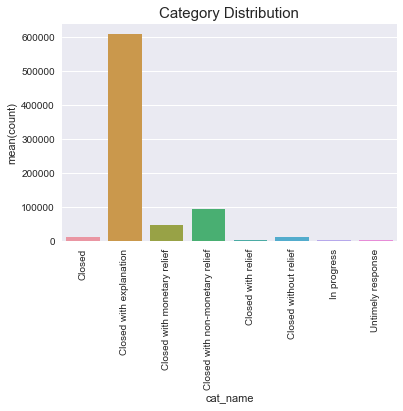

In [33]:
cat = train["Company response to consumer"].value_counts().reset_index().rename(columns={'index': 'cat_name', 'Company response to consumer':'count'})
ax = sns.barplot(x="cat_name", y="count", data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Category Distribution', fontsize=15)
plt.show()

As you can see from the above plot bar that most of the consumer complaints falls into **'Closed with expalnation'** category, after that **'Closed with  non-monetary relief'** then **'Closed with monetary relief'**

## Preparing the corpus for Analysis  

a. Remove Puncuations

b. Remove Digits

c. Remove stop words

d. Lower case words

e. Lemmatization or Stemming

### Removing Punctuation

In [34]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
#Replacing punctuations

punctuation_symbols =[]

for p in punctuation:
    punctuation_symbols.append((p,''))

punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [36]:
import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

### Removing Digits

In [37]:
def remove_digit(s):
    s = ''.join([k for k in s if not k.isdigit()])
    return s

### Remove Stop Words

In [38]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

### Lowercase Words

In [39]:
def to_lower(x):
    return x.lower()

### Product Distribution

In [40]:
train["Product"].nunique()

18

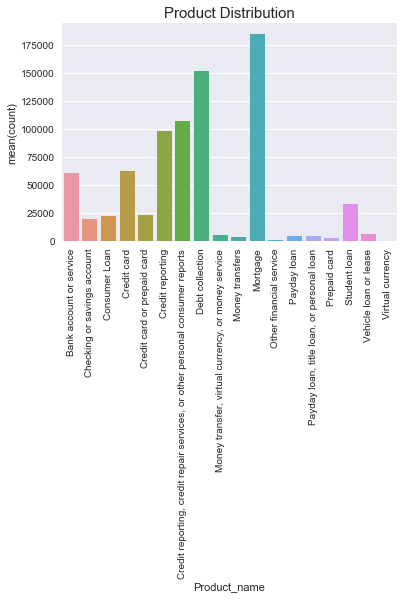

In [41]:
cat = train["Product"].value_counts().reset_index().rename(columns={'index': 'Product_name', 'Product':'count'})
ax = sns.barplot(x="Product_name", y="count", data=cat)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Product Distribution', fontsize=15)
plt.show()

### Issue Distribution

From the below plot we got to know top 10 issues in th dataset.

,Issue,Complaint ID
0,"Loan modification,collection,foreclosure",78520
1,Incorrect information on credit report,71698
2,Incorrect information on your report,61509
3,"Loan servicing, payments, escrow account",54071
4,Cont'd attempts collect debt not owed,42453
5,"Account opening, closing, or management",26584
6,Problem with a credit reporting company's inve...,24138
7,Communication tactics,22350
8,Disclosure verification of debt,21633
9,Attempts to collect debt not owed,20847


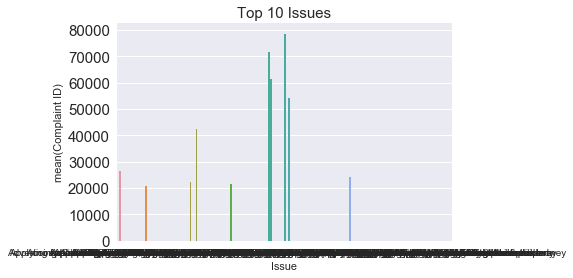

In [42]:
# Display Top 20 Issues By their Categories
top10_issue = train.groupby('Issue', axis=0).count()

df_ID = pd.DataFrame(top10_issue.sort_values('Complaint ID', ascending = False)['Complaint ID'][0:10].reset_index())
ax = sns.barplot(df_ID.Issue, df_ID["Complaint ID"], data=df_ID)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
#ax.set_xticklabels(df_ID.Issue,rotation=60)
ax.set_title('Top 10 Issues', fontsize=15)
#plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df_ID
#plt.show()# Displayd frequency ratio of brand names

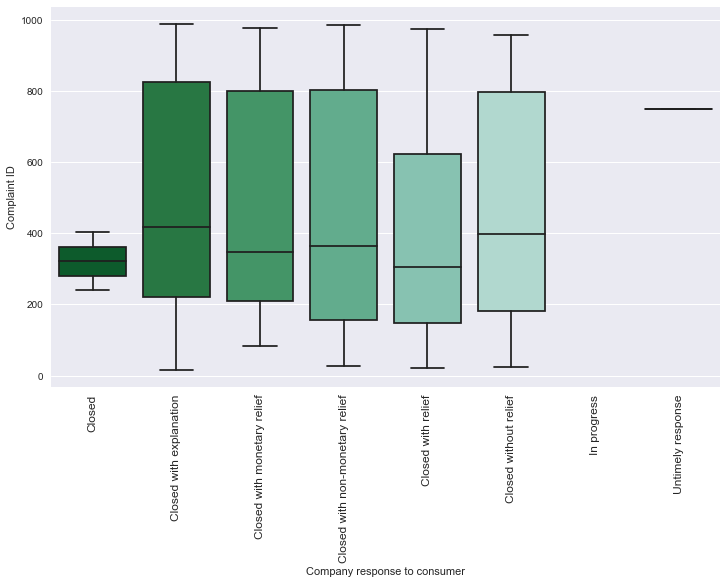

In [43]:
fig, axes = plt.subplots(figsize=(12, 7))
main = train[train["Complaint ID"]<1000]
# Use a color palette
ax = sns.boxplot( x=main["Company response to consumer"], y=main["Complaint ID"], palette="BuGn_r")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)

sns.plt.show()

## Consumer Narrative Analysis

Hypothesis:

Does length play a role in final result?  
Does certain descriptions gives a same result?  
Lenghthier descriptions mean more effort in the process, more authentic, more valuable?  

In [44]:
# Remove Punctuation
combined["Consumer complaint narrative"] = combined["Consumer complaint narrative"].astype(str)

descr = combined[["Consumer complaint narrative", "Company response to consumer"]]
descr['count'] = descr["Consumer complaint narrative"].apply(lambda x : len(str(x)))

descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_digit)
descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_punctuation)
descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(remove_stop_words)

In [45]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

descr["Consumer complaint narrative"] = descr["Consumer complaint narrative"].apply(porter.stem)

In [46]:
descr.shape

(1124716, 3)

In [47]:
descr.tail(10)

,Consumer complaint narrative,Company response to consumer,count
112784,nan,Closed without relief,3
1106502,xxxx year old son receiving credit card offers...,Closed with explanation,1370
262710,nan,Closed with explanation,3
971468,much info early warning showing wrong dispute ...,Closed with explanation,107
994333,open checking saving accounts back xxxxxxxx ke...,Closed with explanation,661
564113,nan,Closed with explanation,3
930608,nan,Closed with explanation,3
895317,nan,Closed with explanation,3
894697,nan,Closed with explanation,3
290426,nan,Closed with explanation,3


In [48]:
#df = descr.groupby("Company response to consumer")['count'].count().reset_index()
#.count().reset_index()
#sns.regplot(x=descr["Company response to consumer"], y=(descr['count']))
#plt.xlabel("word count")
#plt.show()

In [49]:
 combined.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
830888,11/13/2015,Credit card,NaN,Credit determination,NaN,nan,Company chooses not to provide a public response,BARCLAYS BANK DELAWARE,TN,377XX,NaN,Consent not provided,Web,11/17/2015,Closed with non-monetary relief,Yes,No,1654084
526856,02/11/2013,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,nan,NaN,HSBC NORTH AMERICA HOLDINGS INC.,NJ,07111,NaN,NaN,Web,02/13/2013,Closed with explanation,Yes,No,314145
591472,08/04/2015,Credit card,NaN,Other,NaN,nan,Company chooses not to provide a public response,"CITIBANK, N.A.",AZ,85718,Older American,Consent not provided,Web,08/04/2015,Closed with monetary relief,Yes,No,1500828
221150,03/22/2018,Debt collection,Other debt,Written notification about debt,Didn't receive enough information to verify debt,nan,Company believes it acted appropriately as aut...,"Simon’s Agency, Inc",NJ,07740,NaN,NaN,Fax,03/30/2018,Closed with explanation,Yes,NaN,2851121
744204,12/31/2017,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,nan,NaN,"BAYVIEW LOAN SERVICING, LLC",GA,30705,NaN,Other,Web,12/31/2017,Closed with explanation,Yes,NaN,2768499


In [50]:
# to_categorical - Converts Categorical Features 
def to_categorical(df):
    df['Product'] = df['Product'].astype('category')
    df['Sub-product'] = df['Sub-product'].astype('category')
    df['Issue'] = df['Issue'].astype('category')
    df['Sub-issue'] = df['Sub-issue'].astype('category')
    df['Company public response'] = df['Company public response'].astype('category')
    df['Consumer consent provided?'] = df['Consumer consent provided?'].astype('category')
    df['Company response to consumer'] = df['Company response to consumer'].astype('category')
    #df['Sub-product']  =  df['Sub-product'] .cat.add_categories(['Other'])
    #df['Sub-issue'] = df['Sub-issue'].cat.add_categories(['Other'])
    #df['Company public response'] = df['Company public response'].cat.add_categories(['None'])

## Applying Preprocessing Functions

In [51]:
# Applying the pre-processing functions
train_c =train
#handle_missing_values(train)
to_categorical(train)

In [52]:
# Remove Punctuation
train["Consumer complaint narrative"] = train["Consumer complaint narrative"].astype(str)

train["Consumer complaint narrative"] = train["Consumer complaint narrative"].apply(remove_digit)
train["Consumer complaint narrative"] = train["Consumer complaint narrative"].apply(remove_punctuation)

train["Consumer complaint narrative"] = train["Consumer complaint narrative"].apply(remove_stop_words)
#train["Consumer complaint narrative"] = train["Consumer complaint narrative"].replace(['x','X'],'')
train["Product"] = train["Product"].apply(remove_digit)
train["Product"] = train["Product"].apply(remove_punctuation)
train["Product"] = train["Product"].apply(remove_stop_words)

train["Issue"] = train["Issue"].apply(remove_digit)
train["Issue"] = train["Issue"].apply(remove_punctuation)
train["Issue"] = train["Issue"].apply(remove_stop_words)


In [53]:
train["Consumer complaint narrative"].head(10)

830888                                           description
526856                                           description
591472                                           description
221150                                           description
744204                                           description
812813                                           description
1050239    contacted quickenloans possible va mortgage on...
429832     problem wells fargo home mortgagei lived addre...
885063                                           description
251412                                           description
Name: Consumer complaint narrative, dtype: object

### Feature Extraction with text

**Feature Pre-Processing**: Sometimes you can't just fit a dataset into your model and expect good results. Each type of feature has their own way of preprocessing. Choice of preprocessing method also depends on the model we are trying to use.

Since we're working with Text Features, we're going to do a lot of vectorization:

**Tokenization**: split each text into words (bag of words model)  
**Stemming**: removing word inflections (getting the root word)  
**Vectorization**: reducing text into a vector with different types of frequencies for each word (Count Values or TF-IDF Values)

### Bag Of Words

When we vectorize these words, we're doing creating a feature for each word. Also known as, Bag of Words. We lose word ordering

**Solution:** To preserve some ordering, we can introduce n-grams into our vectorization of words (problem: too many features)

one way to reduce dimensions of n-grams is to remove stop words (a, the, is)
**stop words:** we can remove these words becaues they are just there for grammatical structure with little to no meaning
**n-gram**\   with smaller frequencies can highlight and capture important parts of a document/text. This preserves local ordering and can improve model performance.

In [54]:
train.shape

(787301, 19)

In [55]:
# Examine the normalize item description
train =train[train['Consumer complaint narrative'] != 'description']


In [56]:
def dup_char(x):
    return (re.sub('[xx]','',x))

In [57]:
train["Consumer complaint narrative"] = train["Consumer complaint narrative"].astype(str).apply(dup_char)

In [58]:
train.shape

(226385, 19)

In [59]:
# Examine the normalize item description
train['Consumer complaint narrative'][60:70]

706583        wells fargo bank legitimately withdrew  res...
985019     attempted shop good rate car   went   dealersh...
1072165    hello opened citigold checking account citiban...
1000337                late dates    paying partial payme...
1073720    problem actually  fold involves mortgage citib...
1023675    problem capital one bank months account inform...
407908     adverse account credit report afni original cr...
1056834    received loan paid loan said took another loan...
579399     submitted loan modification package found deni...
991675     last year took advantage citibank offer  cash ...
Name: Consumer complaint narrative, dtype: object

In [60]:
#import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

text1 = train['Consumer complaint narrative'].iloc[65]
tokens = word_tokenize(text1)


## TF - IDF

Main Goal - Measure how important a word or phrase is within a collection of documents. Its essentially **weigh down** terms that appear frequently and **scale up** unique terms.

** TF Term Frequency-** ( Number of times terms t appears in a document / Total number of terms in the document)  
** IDF Inverse Document Frequency-** log_e( Total number of documents / Number of documents with term t in it)  
** TF X IDF-** A measure of how important term in a document.  

* When you have a **high** term frequency in a document and it appears in many documents in the corpus = ** Low TFIDF**  
* When you have a **low** term frequency in a document and it appears in **not so many** documents in the corpus = ** High TFIDF**  

**CORPUS =  Collection of documents**  

** Important Parameters**  

1. ngram_range  
2. stop words  
3. lowercase  
4. max_df  :-  max threshold that will ignore a term that has a document frequency higher than that.    
5. min_df  :-  min threshold that will ignore a term that has a document frequency lower than that.  
6. max_features :- get the assigned amount of features with highest amount of term frequencies(scores).  



### Count Vectorizer

Generating new features of **Product Name** and **Issue**

In [61]:
# Apply Count Vectorizer to "Product", this converts it into a sparse matrix 

cv = CountVectorizer(min_df=10)
X_Product = cv.fit_transform(train['Product'])
X_Product

print(str(X_Product.shape))

(226385, 29)


In [62]:
cv = CountVectorizer(min_df=10)
X_Issue = cv.fit_transform(train['Issue'])
X_Issue

print(str(X_Issue.shape))

(226385, 208)


In [77]:
# Apply TFIDF to "Consumer complaint Narrative", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english',norm ='l1')
X_description = tv.fit_transform(train['Consumer complaint narrative'])

print(str(X_description.shape))

(226385, 55000)


#### Observing TF-IDF weights

In [78]:

#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict( dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# Lowest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
credit,1.620461
account,1.849656
report,2.133880
information,2.239886
received,2.240665
time,2.323374
company,2.348559
told,2.351780
called,2.389258
payment,2.416073


In [79]:
# HIghest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
starred starred,12.636850
nv restaurants,12.231384
nv gasoline,12.231384
banklender servicer,12.231384
restaurants view,12.231384
fp fp,12.231384
details nv,12.231384
alleged banklender,12.231384
gasoline view,12.231384
agco,12.231384


In [80]:
# Combine everything together
sparse_merge = hstack((X_description, X_Product, X_Issue)).tocsr()

In [ ]:
def tokenize_string(my_string):
    """ DONE. You should use this in your tokenize function.
    """
    #return re.findall('[\w\-]+', my_string.lower())
    #\W -> Matches any non-alphanumeric character; 
    #this is equivalent to the class [^a-zA-Z0-9_]. 
    
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    no_numbers = my_string.lower().translate({ord(ch): None for ch in '0123456789'})
    word_list = re.sub('\W+', ' ', no_numbers).split()
    stop = set(stopwords.words('english'))
    output = []
    
    for word in word_list:
        if word != "xxxx" and word not in stop:
            word = stemmer.stem(word)
            if len(word) > 2:
                output.append(word)
            
    word_list = output
    
    # preprocessing ->
   
    # remove too low and too high frequency words -> we can't calculate here

    return(word_list)

In [ ]:
def tokenize(data):
    """
    Append a new column to the movies DataFrame with header 'tokens'.
    This will contain a list of strings, one per token, extracted
    from the 'genre' field of each movie. Use the tokenize_string method above.
    Note: you may modify the movies parameter directly; no need to make
    a new copy.
    Params:
      movies...The movies DataFrame
    Returns:
      The movies DataFrame, augmented to include a new column called 'tokens'.
    >>> movies = pd.DataFrame([[123, 'Horror|Romance'], [456, 'Sci-Fi']], columns=['movieId', 'genres'])
    >>> movies = tokenize(movies)
    >>> movies['tokens'].tolist()
    [['horror', 'romance'], ['sci-fi']]
    """
    ###TODO
    
    # step 1 -> do tokenize_string for each row in movies['genres']

    all_words = []
    for row in data['Consumer complaint narrative']:
        #genre_list = re.sub(r'[||)|(]', r' ',row.lower()).split()
        word_list = tokenize_string(row)
        #print(word_list)
        #print(len(genre_list))
        all_words.append(word_list)
    
    # step 2 -> add column tokens in movies
    array = np.array(all_words)
    
    #print(array[:5])
    #print('#list = ',len(array))
    
    new_data = d.assign(tokens = array)
    
    #print(new_movies.head(5))
    return(new_data)  

In [ ]:
def featurize(data):
    """
    Append a new column to the movies DataFrame with header 'features'.
    Each row will contain a csr_matrix of shape (1, num_features). Each
    entry in this matrix will contain the tf-idf value of the term, as
    defined in class:
    tfidf(i, d) := tf(i, d) / max_k tf(k, d) * log10(N/df(i))
    where:
    i is a term
    d is a document (movie)
    tf(i, d) is the frequency of term i in document d
    max_k tf(k, d) is the maximum frequency of any term in document d
    N is the number of documents (movies)
    df(i) is the number of unique documents containing term i
    Params:
      movies...The movies DataFrame
    Returns:
      A tuple containing:
      - The movies DataFrame, which has been modified to include a column named 'features'.
      - The vocab, a dict from term to int. Make sure the vocab is sorted alphabetically as in a2 (e.g., {'aardvark': 0, 'boy': 1, ...})
   
    """
    ###TODO
    #print(movies[:5]) 
    
    #step 1 -> build a vocab and df(term)
    vocab = {}
    vocab_list = []
    df = {}
    
    for tokenization in data['tokens']:
        tokens = list(set(tokenization))
        for term in tokens:
            if term not in vocab.keys():
                vocab.setdefault(term,-1)
             
            if term not in df.keys(): 
                df.setdefault(term,1)
            else :
                df[term] += 1
             
             
    #print('vocab = ', vocab)
    
    vocab_list = sorted(vocab.keys(), key = lambda x:x)
    #print('vocab_list = ', vocab_list)
    
    for i,term in enumerate(vocab_list):
         vocab[term] = i
            
    #        
         
    #print('Sorted vocab = ', sorted(vocab.items()))
    #print('df = ',sorted(df.items(), key=lambda x:x[0]))
    
    # step 2 -> Build a csr_matrix for each row of movies['tokens']
   
    #print('N = ',N)
    
    #[comedy, comedy, comedy, horror]  -> max_k tf(k, d) = 3 
    #[action, comedy,thriller] -> tf(action, d) =1
    # df(i) ->
    #num_features is the total number of unique features across all documents.
    
    N = len(data)
    
    csr_array =[]
    
    for row1 in data['tokens']:
        csr_row = []
        csr_col = []
        csr_data = []
        max_k = 0
       
        max_k = Counter(row1).most_common()[:1][0][1]
        row = list(set(row1))

        #print('removed duplicates =',row)
        for term in row:       
            csr_row.append(0)
            csr_col.append(vocab[term])
            #tfidf(i, d) := tf(i, d) / max_k tf(k, d) * log10(N/df(i))
            tf = Counter(row1)[term]
            #max_k = max_k.most_common()[:1][0][1]
         
            #print('term = %s ---> tf = %d ---> max_k = %d'%(term,tf,max_k))
            tfidf = (tf / max_k) * math.log10(N/df[term])
            csr_data.append(tfidf)
           
         
        #print('csr_row = ',csr_row) 
        #print('csr_col = ',csr_col)
        #print('csr_data=',csr_data)
        X = csr_matrix((csr_data, (csr_row, csr_col)), shape=(1, len(vocab)), dtype=np.float64)
       
        #print('X ->\n',X.toarray())
        csr_array.append(X)
    

    # step 3 -> add column features to movies 
    #print('size of csr_array = ',len(csr_array)) 
    #print('CSR = ',csr_array[:2])  
    new_data = data.assign(features = csr_array)
    #print(new_movies.head(2))
     
    return(new_data,vocab)   
    
    pass

In [ ]:
data = tokenize(d)

In [ ]:
print(data.head(20)['tokens'])
print(data.tail(20)['tokens'])

In [ ]:
#create new features
class_vector = pd.factorize(data['Company response to consumer'])
data['class_vector'] = pd.Series(class_vector[0])
data['combined_product'] = data.apply(lambda x: "%s-%s" % (x['Product'], x['Sub-product']), axis = 1)
data['combined_issue'] = data.apply(lambda x: "%s-%s" % (x['Issue'], x['Sub-issue']), axis = 1)
print(data["class_vector"].head())
print(data["combined_product"].head())
print(data["combined_issue"].head())


In [ ]:
decision_tree_data = data.ix[:, ['combined_product', 'combined_issue']]
clf = tree.DecisionTreeClassifier(max_depth=3)
product_enc = preprocessing.OneHotEncoder()
issue_enc = preprocessing.OneHotEncoder()
x = DataFrameMapper([
        ('combined_product', product_enc), 
        ('combined_issue',issue_enc)
    ])
x_1 = x.fit_transform(decision_tree_data)
x_1

In [ ]:

clf = clf.fit( x_1, y = data['Company response to consumer'].values)

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,   
                         class_names=data['Company response to consumer'].values,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
data, vocab = featurize(data)

In [ ]:
print('vocab:')
print(sorted(vocab.items())[:500])

In [ ]:
print(len(vocab))